In [3]:
import transformers
from datasets import Dataset, DatasetDict, ClassLabel
import pandas as pd
import numpy as np
import evaluate
import torch
from transformers import pipeline

In [4]:
df = pd.read_csv("../data/cleaned/isear_cleaned.csv")
df.head(3)

,text,emotion
0,when a boy tried to fool me so he would be ok ...,anger
1,i felt anger when i saw that i was being misle...,anger
2,once a friend had pushed me and i had fallen o...,anger


In [5]:
# Convert the pandas DataFrame into a Dataset
df_dict = Dataset.from_pandas(df)
df_dict = df_dict.class_encode_column("emotion")


# Realizar la primera división estratificada por la columna 'emotion' para obtener el conjunto de train y test+valid
train_testvalid = df_dict.train_test_split(
    test_size=0.2, stratify_by_column="emotion", seed=46
)

# Dividir el conjunto de test+valid en validación y prueba (50% validación, 50% prueba)
test_valid = train_testvalid["test"].train_test_split(
    test_size=0.5, stratify_by_column="emotion", seed=46
)

# Crear el DatasetDict con train, validation y test
dataset_dict = DatasetDict(
    {
        "train": train_testvalid["train"],
        "validation": test_valid["train"],
        "test": test_valid["test"],
    }
)

# Remover la columna '__index_level_0__' que no es necesaria
dataset_dict = dataset_dict.remove_columns(["__index_level_0__"])

# Verificar el resultado
dataset_dict


Casting to class labels:   0%|          | 0/7534 [00:00<?, ? examples/s]

ValueError: Column name ['__index_level_0__'] not in the dataset. Current columns in the dataset: ['text', 'emotion']

In [72]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)


def preprocess_function(examples, func_tokenizer):
    return func_tokenizer(examples["text"], truncation=True)


tokenized_dataset = dataset_dict.map(
    preprocess_function,
    batched=True,
    # num_proc=20,
    fn_kwargs={"func_tokenizer": tokenizer},
)

tokenized_dataset = tokenized_dataset.rename_column("emotion", "label")
print(tokenized_dataset)

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/754 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 6027
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 753
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 754
    })
})


In [73]:
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

id2label = {
    0: "anger",
    1: "disgust",
    2: "fear",
    3: "guilt",
    4: "joy",
    5: "sadness",
    6: "shame",
}
label2id = {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "guilt": 3,
    "joy": 4,
    "sadness": 5,
    "shame": 6,
}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=7, id2label=id2label, label2id=label2id
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
training_args = transformers.TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    num_train_epochs=20,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
)

/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [75]:
recall = evaluate.load("recall")
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
f1 = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    pre = precision.compute(
        predictions=predictions, references=labels, average="weighted"
    )["precision"]
    rec = recall.compute(
        predictions=predictions, references=labels, average="weighted"
    )["recall"]
    f1_score = f1.compute(
        predictions=predictions, references=labels, average="weighted"
    )["f1"]
    acc = accuracy.compute(predictions=predictions, references=labels)["accuracy"]

    return {"precision": pre, "recall": rec, "f1": f1_score, "accuracy": acc}


trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.212110,0.660411,0.623342,0.611819,0.623342
2,No log,0.940745,0.679804,0.679045,0.675059,0.679045
3,No log,0.861924,0.709336,0.706897,0.707321,0.706897
4,No log,0.863319,0.723961,0.717507,0.718522,0.717507
5,No log,0.847826,0.724313,0.720159,0.720440,0.720159
6,0.923500,0.877021,0.728411,0.720159,0.720292,0.720159
7,0.923500,0.913028,0.726986,0.724138,0.723103,0.724138
8,0.923500,0.948107,0.717772,0.712202,0.712689,0.712202
9,0.923500,1.036212,0.707482,0.705570,0.703256,0.705570
10,0.923500,1.050014,0.718512,0.718833,0.717487,0.718833


TrainOutput(global_step=1900, training_loss=0.3340263527318051, metrics={'train_runtime': 638.6378, 'train_samples_per_second': 188.745, 'train_steps_per_second': 2.975, 'total_flos': 1902658917438270.0, 'train_loss': 0.3340263527318051, 'epoch': 20.0})

In [79]:
trainer.evaluate()

{'eval_loss': 0.8478260040283203,
 'eval_precision': 0.7243129801351008,
 'eval_recall': 0.7201591511936339,
 'eval_f1': 0.7204401267960703,
 'eval_accuracy': 0.7201591511936339,
 'eval_runtime': 2.1809,
 'eval_samples_per_second': 345.721,
 'eval_steps_per_second': 5.502,
 'epoch': 20.0}

In [80]:
trainer.save_model("models/distilbert-base-uncased-finetuned")

In [81]:
# trainer.save_model("./my_model")
text = "You shouldnt said that. I hate you!"
classifier = pipeline(
    "text-classification",
    model="models/distilbert-base-uncased-finetuned/",
    device="cuda",
)
print(classifier(text))

[{'label': 'guilt', 'score': 0.5378169417381287}]


In [4]:
train_ds = dataset_dict["train"]
train_ds[0]

{'text': 'whenever i am alone in a dark room, walk alone on the street, sleep alone in the room at night or see something which is only partly visible.  this emotion was very strong when as an 8 year   old child i saw something horrible.',
 'emotion': 2}

In [5]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'emotion': ClassLabel(names=['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame'], id=None)}


In [6]:
# Function to convert integer label to string label
def emotion_int2str(row):
    return class_label.int2str(row)


# Function to convert string label to integer label
def emotion_str2int(row):
    return class_label.str2int(row)

## Train model

In [7]:
import torch

torch.cuda.is_available()

True

## Simple classifier

In [27]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6268260292164675

## Dummy classifier

In [28]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.14475431606905712

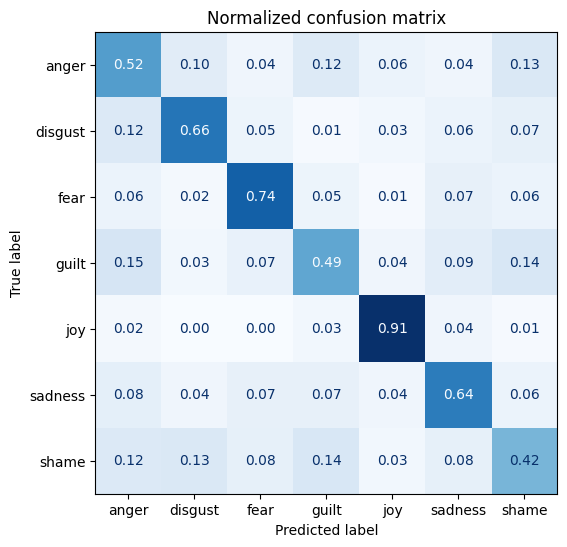

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Base model BERT

In [30]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=num_labels
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [32]:
from huggingface_hub import notebook_login

notebook_login()

In [33]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error",
)

2024-09-17 23:50:18.287020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 23:50:18.301870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 23:50:18.306225: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 23:50:18.320041: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 23:50:19.777047: W tensorflow/compiler/tf2

In [34]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer,
)
trainer.train()

ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,attention_mask.